In [1]:
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler

In [2]:
import os
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

In [3]:
BATCH_SIZE = 256
START_TOKN, END_TOKN, PAD_TOKN = "<", ">", "-"

In [4]:
f = open("names.txt", 'r', encoding='utf-8')
raw_names = f.read().splitlines()
f.close()

raw_names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
MAX_LEN = max([len(name) for name in raw_names]) + 2 # 2 extra characters for START_TOKN and END_TOKN
BLOCK_SIZE = MAX_LEN - 1
BLOCK_SIZE, MAX_LEN

(16, 17)

In [6]:
CHARS = sorted(list(set("".join(raw_names)))) + [START_TOKN, END_TOKN, PAD_TOKN] # add special characters at the end
"".join(CHARS)

'abcdefghijklmnopqrstuvwxyz<>-'

In [7]:
stoi = {ch: i for i, ch in enumerate(CHARS)}
itos = {i: ch for i, ch in enumerate(CHARS)}

text = START_TOKN + "hello" + PAD_TOKN + "world" + END_TOKN
"".join([itos[i] for i in [stoi[ch] for ch in text]])

'<hello-world>'

In [8]:
START_IDX, END_IDX, PAD_IDX = stoi[START_TOKN], stoi[END_TOKN], stoi[PAD_TOKN]

START_IDX, END_IDX, PAD_IDX

(26, 27, 28)

In [9]:
class NameDataset(Dataset):
    def __init__(self, names):
        self.x = []
        self.y = []
        for name in names:
            name = (START_TOKN + name + END_TOKN + PAD_TOKN*MAX_LEN)[:MAX_LEN]
            self.x.append([stoi[ch] for ch in name[:-1]])
            self.y.append([stoi[ch] for ch in name[1:]])
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [10]:
split = int(len(raw_names)*0.9)
random.seed(42)
random.shuffle(raw_names)
train_data = NameDataset(raw_names[:split])
val_data = NameDataset(raw_names[split:])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=RandomSampler(train_data, replacement=True, num_samples=BATCH_SIZE))
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

len(train_loader), len(val_loader)

(1, 13)

In [11]:
class Attention(nn.Module):
    def __init__(self, emb=32, heads=4):
        super().__init__()
        self.heads = heads
        self.key = nn.Linear(emb, emb)
        self.qry = nn.Linear(emb, emb)
        self.val = nn.Linear(emb, emb)
        self.register_buffer('tril', torch.tril(torch.ones(BLOCK_SIZE, BLOCK_SIZE)).view(1, 1, BLOCK_SIZE, BLOCK_SIZE))
        self.proj = nn.Linear(emb, emb)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):                                                   # (B, T, C)
        B, T, C = x.shape
        H = self.heads
        k = self.key(x).view(B, T, H, C//H).transpose(1, 2)                 # (B, H, T, C/H)
        q = self.qry(x).view(B, T, H, C//H).transpose(1, 2)                 # (B, H, T, C/H)
        v = self.val(x).view(B, T, H, C//H).transpose(1, 2)                 # (B, H, T, C/H)
        att = (q @ k.transpose(-1, -2)) * (1.0 / np.sqrt(k.size(-1)))       # (B, H, T, T)
        att = att.masked_fill((self.tril == 0), -float(np.inf))             # (B, H, T, T)
        att = F.softmax(att, dim=-1)                                        # (B, H, T, T)
        y = (att @ v).transpose(1, 2)                                       # (B, T, H, C/H)
        y = y.contiguous().view(B, T, C)                                    # (B, T, C)
        out = self.proj(y)                                                  # (B, T, C)
        out = self.dropout(out)                                             # (B, T, C)
        return out

In [12]:
class FeedForward(nn.Module):
    def __init__(self, emb=32, mlp_emb=128):
        super().__init__()
        self.lin = nn.Linear(emb, mlp_emb)
        self.proj = nn.Linear(mlp_emb, emb)
        self.dropout = nn.Dropout(0.05)
        
    def forward(self, x):                                                    # (B, T, C)
        x = self.lin(x)                                                      # (B, T, M)
        x = F.tanh(x)                                                        # (B, T, M)
        y = self.proj(x)                                                     # (B, T, C)
        y = self.dropout(y)                                                  # (B, T, C)
        return y

In [13]:
class Block(nn.Module):
    def __init__(self, emb=32, heads=4, mlp_emb=128):
        super().__init__()
        self.attention = Attention(emb, heads)
        self.norm_1 = nn.LayerNorm(emb)
        self.norm_2 = nn.LayerNorm(emb)
        self.feed_forward = FeedForward(emb, mlp_emb)
        
    def forward(self, x):                                                     # (B, T, C)
        n1 = self.norm_1(x)                                                   # (B, T, C)
        att = x + self.attention(n1)                                          # (B, T, C)
        n2 = self.norm_2(att)                                                 # (B, T, C)
        ff = att + self.feed_forward(n2)                                      # (B, T, C)
        return ff

In [14]:
class Transformer(nn.Module):
    def __init__(self, emb=32, heads=4, mlp_emb=128, layers=2):
        super().__init__()
        self.embedding = nn.Embedding(len(CHARS), emb)
        self.pos_embedding = nn.Embedding(BLOCK_SIZE, emb)
        self.blocks = nn.Sequential(*[Block(emb, heads, mlp_emb) for _ in range(layers)])
        self.norm = nn.LayerNorm(emb)
        self.decoder = nn.Linear(emb, len(CHARS))
        
    def forward(self, x):                                                     # (B, T)
        emb = self.embedding(x)                                               # (B, T, C)
        pos = torch.arange(BLOCK_SIZE, device=x.device)                       # (T)
        pos = self.pos_embedding(pos)                                         # (T, C)
        out = self.blocks(emb + pos)                                          # (B, T, C)
        out = self.norm(out)                                                  # (B, T, C)
        logits = self.decoder(out)                                            # (B, T, vocab_size)
        return logits

In [15]:
@torch.no_grad
def get_accuracy(logits, y):
    outs = logits.argmax(dim=-1)
    mask = (y != PAD_IDX)
    matches = (y == outs) & mask
    num_matches = matches.sum().item()
    num_total = mask.sum().item()
    if num_total == 0:
        return float('nan')
    else:
        return 100.0 * num_matches / num_total

In [16]:
def train(model, loader, steps=100, lr=1e-3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    stats = {"loss": [], "ratio": [], "accuracy": []}
    model.to("cuda")
    model.train()
    
    for _ in range(steps):
        x, y = next(iter(loader))
        x, y = x.to("cuda"), y.to("cuda")
        logits = model(x)
        loss = criterion(logits.view(-1, len(CHARS)), y.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():        
            stats["loss"].append(loss.item())
            ratios = []
            for p in model.parameters():
                if p.grad is None:
                    continue
                update_mean = ((lr * p.grad)**2).mean().item()
                weight_mean = ((p.data)**2).mean().item()
                if weight_mean == 0:
                    ratios.append(np.nan)
                else:
                    ratios.append(update_mean/weight_mean)
            stats["ratio"].append(ratios)
            accuracy = get_accuracy(logits, y)
            stats["accuracy"].append(accuracy)
    return stats

In [17]:
@torch.no_grad()
def validate(model, loader):
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    stats = {"loss": [], "accuracy": []}
    model.to("cuda")
    model.eval()
    
    for x, y in loader:
        x, y = x.to("cuda"), y.to("cuda")
        logits = model(x)
        loss = criterion(logits.view(-1, len(CHARS)), y.view(-1))
        stats["loss"].append(loss.item())
        stats["accuracy"].append(get_accuracy(logits, y))
    return stats

In [18]:
@torch.no_grad()
def makemore(model, starter=""):
    output = list(starter)
    model.to("cuda")
    model.eval()

    while True:
        x_ch = ([START_TOKN] + output)[-BLOCK_SIZE:]
        x_ch = (x_ch + [PAD_TOKN]*BLOCK_SIZE)[:BLOCK_SIZE]
        x = torch.tensor([stoi[ch] for ch in x_ch], device="cuda").unsqueeze(0)
        idx = min(len(output), BLOCK_SIZE-1)
        logits = model(x)[:,idx,:]
        probs = F.softmax(logits, dim=-1)
        y_idx = torch.multinomial(probs, num_samples=1).item()
        y = itos[y_idx]

        if y == END_TOKN:
            break
        elif y in [START_TOKN, PAD_TOKN]:
            continue

        output.append(y)

    return "".join(output)

In [19]:
stats = {"loss": [], "ratio": [], "accuracy": []}

model = Transformer(emb=64, heads=8, mlp_emb=64, layers=8)
model.to("cuda")
sum(p.numel() for p in model.parameters())

206621

In [21]:
epochs = 10

print("Training...")
for epoch in range(epochs):
    train_stats = train(model, train_loader, steps=100, lr=10**(-(2.5)))
    stats["loss"].extend(train_stats["loss"])
    stats["ratio"].extend(train_stats["ratio"])
    stats["accuracy"].extend(train_stats["accuracy"])
    train_loss = sum(train_stats["loss"])/len(train_stats["loss"])
    train_acc = sum(train_stats["accuracy"])/len(train_stats["accuracy"])
    if (((epoch+1) % max(1, (epochs//10))) == 0) or (epoch+1 == epochs):
        val_stats = validate(model, val_loader)
        val_loss = sum(val_stats["loss"])/len(val_stats["loss"])
        val_acc = sum(val_stats["accuracy"])/len(val_stats["accuracy"])
        print(f"""Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f},
              Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Total Steps: {len(stats["loss"])}""")

Training...
Epoch: 1, Training Loss: 1.9730, Training Acc: 37.8482,
              Val Loss: 2.0217, Val Acc: 36.2598, Total Steps: 1100
Epoch: 2, Training Loss: 1.9631, Training Acc: 37.8710,
              Val Loss: 2.0158, Val Acc: 36.9136, Total Steps: 1200
Epoch: 3, Training Loss: 1.9558, Training Acc: 38.1922,
              Val Loss: 2.0085, Val Acc: 36.6188, Total Steps: 1300
Epoch: 4, Training Loss: 1.9482, Training Acc: 38.2739,
              Val Loss: 2.0048, Val Acc: 37.2291, Total Steps: 1400
Epoch: 5, Training Loss: 1.9402, Training Acc: 38.4451,
              Val Loss: 2.0034, Val Acc: 37.1768, Total Steps: 1500
Epoch: 6, Training Loss: 1.9336, Training Acc: 38.8073,
              Val Loss: 2.0022, Val Acc: 37.1695, Total Steps: 1600
Epoch: 7, Training Loss: 1.9327, Training Acc: 38.8385,
              Val Loss: 1.9964, Val Acc: 37.2834, Total Steps: 1700
Epoch: 8, Training Loss: 1.9218, Training Acc: 39.0713,
              Val Loss: 1.9938, Val Acc: 37.2697, Total Steps: 1

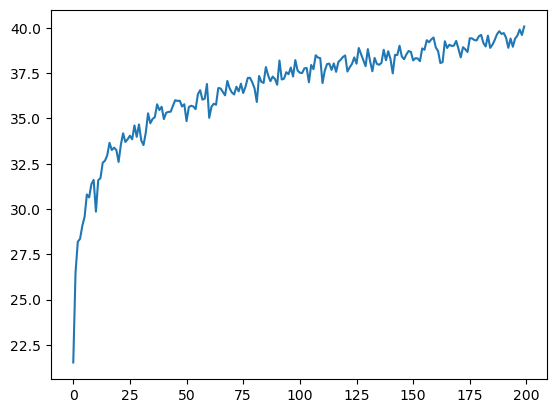

200

In [22]:
accuracy = torch.tensor(stats["accuracy"])
accuracy = accuracy.view(-1, 10).mean(dim=1)
plt.plot(accuracy)
plt.show()
len(accuracy)

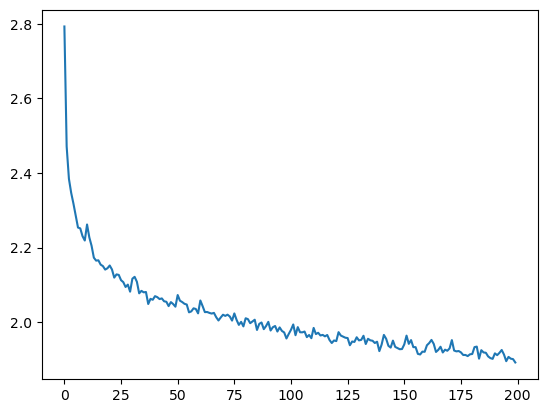

200

In [23]:
losses = torch.tensor(stats["loss"])
losses = losses.view(-1, 10).mean(dim=1)
plt.plot(losses)
plt.show()
len(losses)

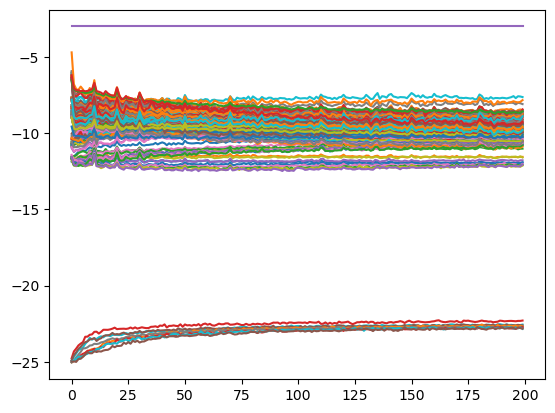

In [24]:
ratios = torch.tensor(stats['ratio'])
_layers = ratios.shape[1]
ratios = ratios.view(-1, 10, _layers).mean(dim=1).T.log10()
for ratio in ratios:
    plt.plot(ratio)
e3 = torch.ones_like(ratio)*(-3)
plt.plot(e3)
plt.show()

In [210]:
N, P = 10**(3), 100

gen_names = {True: [], False: []}
for i in range(N):
    name = makemore(model)
    key = (name in raw_names)
    gen_names[key].append(name)
    if i < P:
        print(f"{name}: {key}")
    
print(len(gen_names[False])/N)

hallowa: False
emmalee: True
torray: False
emberlin: True
gavyn: True
dallen: True
carmella: True
livi: True
zakhira: False
azabhel: False
lexie: True
alaza: False
kdonta: False
aubrille: False
lilen: False
rivynn: False
tyan: False
lakely: True
fadav: False
maron: False
cluot: False
maribe: False
zophia: True
mckanna: False
faithl: False
isomar: False
alyss: True
ahmid: False
mier: False
yaran: False
theodana: False
cadence: True
luka: True
nalani: True
khani: True
teyla: True
aryin: False
chisyn: False
payler: False
journey: True
georgi: True
jwen: False
kharlen: False
aiden: True
kha: False
kalysha: False
haytab: False
killae: False
cortney: True
darai: False
rohan: True
edmarion: False
josandra: False
telimario: False
jimiel: False
suila: False
danny: True
danil: True
shalea: False
jarmison: False
carrith: False
adward: False
dalen: True
asiah: True
jiremy: False
zannee: False
jersa: False
darshya: False
danel: True
rydon: False
dana: True
koby: True
aizarah: False
inessa: True
ble

### Transformer(emb=64, heads=8, mlp_emb=256, layers=2)
01. no droput: lr=1e-3, 10k steps: 1.8946, 2.0217
02. FF droput (0.05): lr=1e-3, 10k steps: 1.9197, 2.0081
03. FF droput (0.20): lr=1e-3, 10k steps: 1.9664, 2.0433
04. FF droput (0.20): lr=1e-3, 20k steps: 1.9151, 2.0321
05. FF droput (0.10): lr=1e-3, 10k steps: 1.9323, 2.0193
06. FF droput (0.10): lr=1e-3, 15k steps: 1.8979, 2.0166
07. FF droput (0.05); Att droput (0.10): lr=1e-3, 10k steps: 1.9463, 2.0103
08. FF droput (0.05); Att droput (0.10): lr=1e-3, 15k steps: 1.9081, 1.9941
09. FF droput (0.05); Att droput (0.20): lr=1e-3, 10k steps: 1.9654, 2.1032
10. FF droput (0.05); Att droput (0.20): lr=1e-3, 15k steps: 1.9381, 1.9959
11. FF droput (0.05); Att droput (0.20); qry(bias)=False; lr=1e-3; 10k steps: 1.9675, 2.0078
12. FF droput (0.05); Att droput (0.20); qry(bias)=False; lr=1e-2; 10k steps: 2.1931, 2.1712
13. FF droput (0.05); Att droput (0.20); qry(bias)=False; lr=1e-4; 10k steps: 2.0355, 2.0425
14. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); lr=1e-3; 10k steps: 1.9550, 1.9988
15. FF droput (0.05); Att droput (0.20); TransferNorm(); lr=1e-3; 10k steps: 1.9620, 2.0050
16. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); FF 1 layer; lr=1e-3; 10k steps: 1.9884, 2.0238
17. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); FF 1 layer; lr=1e-3; 15k steps: 1.9463, 2.0067
17. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); FF 1 layer; lr=1e-3; 40k steps: 

### Transformer(emb=64, heads=8, mlp_emb=256, layers=4)
18. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); FF 1 layer; lr=1e-3; 10k steps: 1.9533, 2.0156
19. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); FF 1 layer; lr=1e-3; 15k steps: 1.8986, 1.9867

### Transformer(emb=32, heads=8, mlp_emb=256, layers=10)
20. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); FF 1 layer; lr=1e-3; 10k steps: 1.9947, 2.0178

### Transformer(emb=64, heads=8, mlp_emb=128, layers=6)
21. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); FF 1 layer; lr=1e-3; 10k steps: 1.9176, 1.9918

### Transformer(emb=64, heads=8, mlp_emb=64, layers=8)
21. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); FF 1 layer; lr=1e-3; 10k steps: 1.8897, 1.9936

### Transformer(emb=64, heads=1, mlp_emb=64, layers=8)
21. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); FF 1 layer; lr=1e-3; 10k steps: 1.9655, 2.0071

### Transformer(emb=64, heads=32, mlp_emb=64, layers=8)
22. FF droput (0.05); Att droput (0.20); qry(bias)=False; TransferNorm(); FF 1 layer; lr=1e-3; 10k steps: 1.8992, 1.9860